In [ ]:
import os
import pandas as pd
from tqdm import tqdm_notebook
from ast import literal_eval
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import numpy as np
from utils import featureEngineer, runLGB

In [0]:
train = pd.read_csv("./data/train.csv", index_col=0, low_memory=False)
test = pd.read_csv("./data/test.csv", index_col=0, low_memory=False)
submiss = pd.read_csv("./data/sample_submission.csv", low_memory=False)

## Feature engineer

In [ ]:
data_full = featureEngineer(train, test, submiss)

In [ ]:
cate_features = data_full.select_dtypes(include=['bool', 'object']).columns
num_features = data_full.select_dtypes(exclude=['bool', 'object']).columns

In [0]:
features_missing = [feature for feature in data_full.columns if any(data_full[feature].isnull())]
print(len(features_missing))

for col in features_missing:
    print(f'{col} has {data_full[col].isnull().sum()/len(data_full[col])} missing values')

In [0]:
for col in num_features:
    data_full[col] = data_full[col].fillna(-1)
data_full[cate_features] = data_full[cate_features].fillna('Unknown')

for col in data_full[cate_features]:
    print(f'{col} has {data_full[col].nunique()} different values')

In [ ]:
LB_features = [feature for feature in cate_features if data_full[feature].nunique() > 1000]
OH_features = list(set(cate_features) - set(LB_features))

print(len(LB_features), len(OH_features))

In [0]:
LB_encoder = LabelEncoder()
OH_encoder = OneHotEncoder(sparse=False)

for feature in LB_features:
    data_full[feature] = LB_encoder.fit_transform(data_full[feature])

OH_encoded_features = pd.DataFrame(OH_encoder.fit_transform(data_full[OH_features].astype(str)))
OH_encoded_features.index = data_full.index

data_full = data_full.drop(columns=OH_features).join(OH_encoded_features)

In [0]:
encoded_train_full = data_full[:len(train)]
encoded_test_full = data_full[len(train):]

encoded_test_full = encoded_test_full.drop(columns=['label'])

In [0]:
X_train_full = encoded_train_full.drop(columns=['label'])
y_train_full = encoded_train_full.label

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

params = {'num_leaves': 512,
          'min_child_weight': 0.03,
          'feature_fraction': 0.4,
          'bagging_fraction': 0.4,
          'min_data_in_leaf': 128,
          'objective': 'binary',
          'max_depth': 7,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.6,
          'random_state': 47,
          #'device' : 'gpu',
          #'gpu_platform_id' : 0,
          #'gpu_device_id' : 0
         }

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

model = lgb.train(params,  dtrain, valid_sets = [dtrain, dvalid], verbose_eval=False, early_stopping_rounds=50)

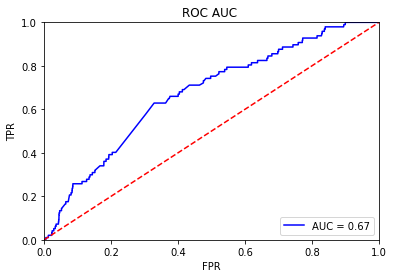

In [0]:
preds = model.predict(X_valid)

fpr, tpr, threshold = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC AUC ')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:0.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.show()

In [0]:
submiss_dir = './submiss'

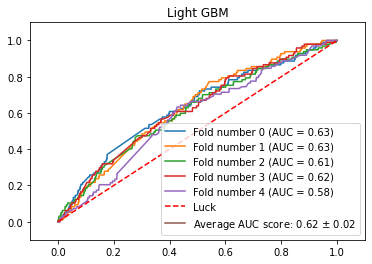

In [0]:
%%time
runLGB(model=None,
      train_data = X_train_full, 
      labels=y_train_full, 
      test_data=encoded_test_full,
      index=test.index,
      n_folds=5,
      submiss_dir=submiss_dir)

In [0]:
folds = StratifiedKFold(n_splits=5, shuffle=True)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train_full.columns

for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train_full, y_train_full)):

    trn_data = lgb.Dataset(X_train_full.loc[trn_idx], label=y_train_full.loc[trn_idx])
    val_data = lgb.Dataset(X_train_full.loc[test_idx], label=y_train_full.loc[test_idx])
    clf = lgb.train(params, trn_data, valid_sets = [val_data], verbose_eval=False, early_stopping_rounds=50)
    
    feature_importances[f'fold_{fold + 1}'] = clf.feature_importance()
    aucs.append(clf.best_score['valid_0']['auc'])
    print(f"Training on fold {fold+1}. AUC score {clf.best_score['valid_0']['auc']:.2f}")

print('Mean AUC:', np.mean(aucs))

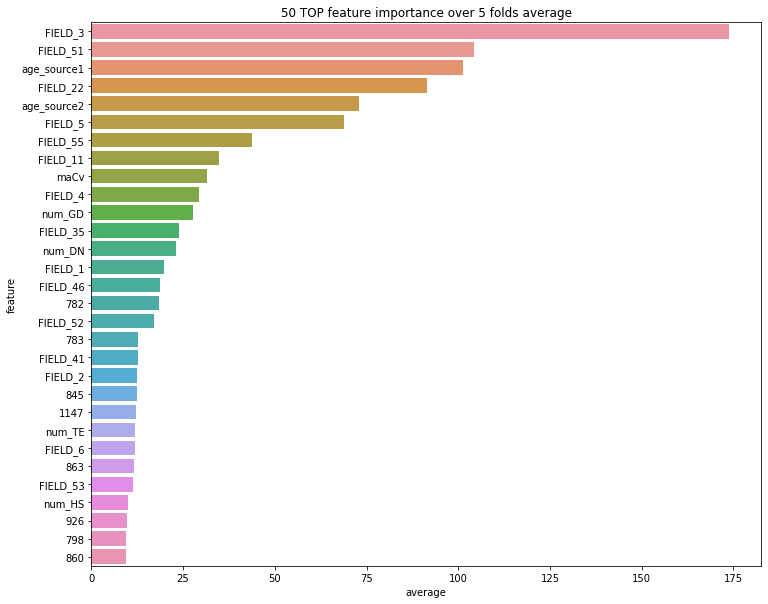

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(12,10))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False)[:30], x='average', y='feature')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))
plt.savefig('Feature_Importance.png')
plt.show()

In [0]:
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train_full, y_train_full)